## Advanced Lane Finding

//TODO
* Camera calibration
* distorion correction
* color/gradient threshold
* Perspective transform
* Detect lane lines
* Calculate curvature

In [1]:
# import all needed lib here
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
%matplotlib inline

In [2]:
# Camera calibration
# Read all in of calibration images
def generate_obj_image_points(root_path):
    images = glob.glob(root_path+'/calibration*.jpg')

    #prepare object point
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx, 3), np.float32)
    #tricky here to get x,y coordinate since z is zero we don't care
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # get x,y coordinate

    # arrays of object and image points
    objpoints = []
    imgpoints = []

    for image_path in images:
        img = mpimg.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)                
    
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist   

def display_2_images(img1, img2):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(img1)
  ax1.set_title('Original Image', fontsize=50)
  ax2.imshow(img2)
  ax2.set_title('Dest Image', fontsize=50)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

objpoints,imgpoints = generate_obj_image_points('./camera_cal')

(720, 1280, 3)


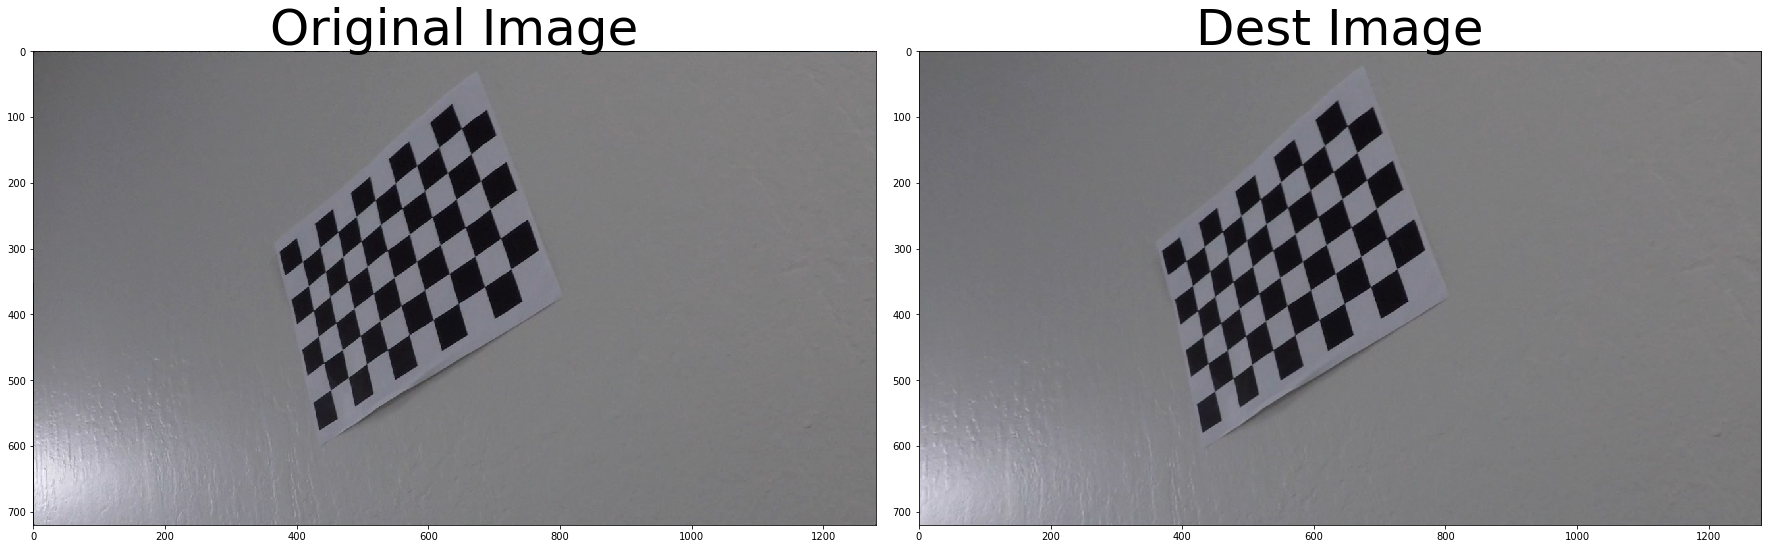

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
index = random.randint(0,len(images))
img_test = mpimg.imread(images[index])
print(img_test.shape)
img_calibrate = cal_undistort(img_test, objpoints, imgpoints)
display_2_images(img_test, img_calibrate)

### Color and Gradient threshold

In [6]:
def mask_with_threshold(input_v, thresh):
    # create mask and apply threshold
    mask = np.zeros_like(input_v)
    mask[(input_v >= thresh[0]) & (input_v <= thresh[1])] = 1
    return mask

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_RGB2GRAY)
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return mask_with_threshold(scaled_sobel, thresh)
    
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # magnitude ==> sqrt(x^2 + y^2)
    mag = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8 bit
    scaled_mag = np.unit8(255*mag/np.max(mag))
    return mask_with_threshold(scaled_mag, thresh)
    
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)): 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arc_v = np.arctan2(abs_sobely, abs_sobelx)
    return mask_with_threshold(arc_v, thresh)

def color_threshold(image, channel, thresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    channel_v = None
    if channel == 'R':
        channel_v = image[:,:,0]
    elif channel == 'G':        
        channel_v = image[:,:,1]
    elif channel == 'B':        
        channel_v = image[:,:,2]
    elif channel == 'H':
        channel_v = hls[:,:,0]
    elif channel == 'L':        
        channel_v = hls[:,:,1]
    elif channel == 'S':        
        channel_v = hls[:,:,2]
        
    return mask_with_threshold(channel_v, thresh)